In [2]:
#This notebook is based from a notebook of the user Leobewin1 of kaggle
#Link of based notebook: https://www.kaggle.com/leoisleo1/future-sales-3
import numpy as np
import pandas as pd
import gc
import matplotlib.pyplot as plt
import re
import datetime
import seaborn as sns
import os
from itertools import product
from sklearn import *
from xgboost import XGBRegressor

In [3]:
#Functions
#Use for count since 1 to endNumber
def intLine(endNumber):
    keep=list()
    for i in range(endNumber):
        keep.append(i)
    return keep
#For the letters
def n_c(old):
    old=old.lower()
    old=old.partition('(')[0]
    old=old.partition('[')[0]
    old=re.sub('[^A-Za-z0-9А-Яа-я]+','',old)
    old=old.strip()
    return old 
#For replace the letters
def use_replace(data_frame,name):
    data_frame[name]=data_frame[name].replace('[^A-Za-z0-9А-Яа-я]+',' ').str.lower()
    return data_frame
#Use for cleaning data
def cleaning(data_set):
    data_set.loc[data_set.shop_id==0,'shop_id']=57
    data_set.loc[data_set.shop_id==1,'shop_id']=58
    data_set.loc[data_set.shop_id==10,'shop_id']==11
    return data_set
#Use for the features
def feature_us(data_frame,x,column):
    for col in column:
        print(col)
        temporal_data_frame = data_frame[["date_block_num", "shop_id","item_id",col ]]
        for i in x:
            change = temporal_data_frame.copy()
            change.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            change.date_block_num = change.date_block_num + i
            data_frame = pd.merge(data_frame, change, on=['date_block_num','shop_id','item_id'], how='left')
            
    return data_frame
#Use for define a limit in a dataFrame
def featureador(dataFrame,columnName,intype):
    if intype ==8:
        dataFrame[columnName]=dataFrame[columnName].astype(np.int8)
    elif intype ==16:
        dataFrame[columnName]=dataFrame[columnName].astype(np.int16)
    return dataFrame
#For work in features
def work_features(ls,columnUsed,x_list,named):
    namedUsing=str(np.squeeze(named))
    ls_g=list_sales.groupby(columnUsed).agg({'item_cnt_month':'mean'})
    ls_g.columns=named
    ls_g.reset_index(inplace=True)
    
    
    ls=pd.merge(ls,ls_g,on=columnUsed,how='left')
    ls[namedUsing]=ls[namedUsing].astype(np.float16)
    ls=feature_us(ls,x_list,named)
    ls.drop(named,axis=1,inplace=True)
    return ls
def s_using(samples):
    for i in x_list:
        if samples['delta_price_lag_'+str(i)]:
            return samples['delta_price_lag_'+str(i)]
    return 0

In [4]:
#We read all the files CSV
items=pd.read_csv('items.csv')
categories=pd.read_csv('item_categories.csv')
shops=pd.read_csv('shops.csv')
sales_training=pd.read_csv('sales_train.csv')
sales_testing=pd.read_csv('test.csv')
sample_submission=pd.read_csv('sample_submission.csv')

In [5]:
#See all the files
line="\n_________________\n"
print(items.head(),line,categories.head(),
      line,shops.head(),line,sales_training.head(),line,sales_testing.head(),line,sample_submission.head())

                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40   
_________________
         item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4 
_________________
                         shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
1   !Якутск ТЦ "Центральный" фран        1
2                Адыгея ТЦ "Мега"     

# Data visualization

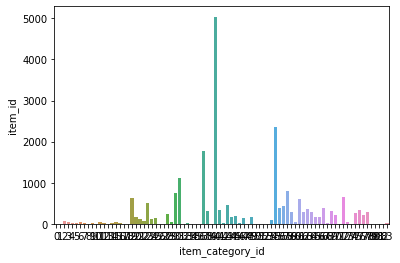

In [6]:
#Barplot of each category
ax1=items.groupby(['item_category_id']).count()
ax1=ax1.sort_values(by='item_id')
ax1=ax1.reset_index()
%matplotlib inline
sns.barplot(ax1['item_category_id'],ax1['item_id'])

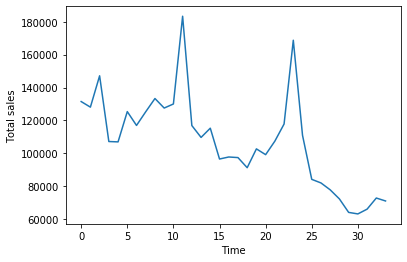

In [7]:
#Timeline of item cnt day
ax2_=sales_training.groupby(['date_block_num'])['item_cnt_day'].sum()
plt.xlabel('Time')
plt.ylabel('Total sales')
plt.plot(ax2_)

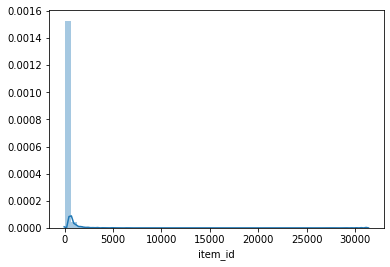

In [8]:
ax3=sales_training.groupby(['item_id'])['item_id'].count()
sns.distplot(ax3)

(array([2.1599e+04, 1.5100e+02, 3.6000e+01, 1.3000e+01, 5.0000e+00,
        1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.000000e+00, 1.567950e+03, 3.134900e+03, 4.701850e+03,
        6.268800e+03, 7.835750e+03, 9.402700e+03, 1.096965e+04,
        1.253660e+04, 1.410355e+04, 1.567050e+04, 1.723745e+04,
        1.880440e+04, 2.037135e+04, 2.193830e+04, 2.350525e+04,
        2.507220e+04, 2.663915e+04, 2.820610e+04, 2.977305e+04,
        3.134000e+04]),
 <a list of 20 Patch objects>)

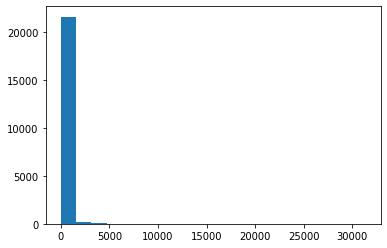

In [9]:
plt.hist(ax3,20)

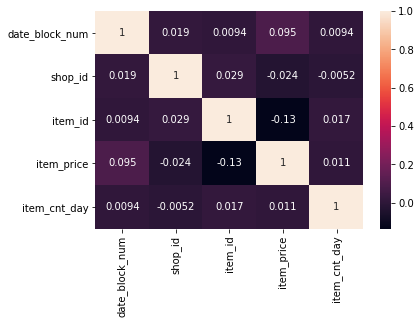

In [10]:
corr_coef=sales_training.corr(method='pearson')
sns.heatmap(corr_coef,annot=True)

In [11]:
print(sales_training.describe(),line,items.describe(),line)

       date_block_num       shop_id       item_id    item_price  item_cnt_day
count    2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06  2.935849e+06
mean     1.456991e+01  3.300173e+01  1.019723e+04  8.908532e+02  1.242641e+00
std      9.422988e+00  1.622697e+01  6.324297e+03  1.729800e+03  2.618834e+00
min      0.000000e+00  0.000000e+00  0.000000e+00 -1.000000e+00 -2.200000e+01
25%      7.000000e+00  2.200000e+01  4.476000e+03  2.490000e+02  1.000000e+00
50%      1.400000e+01  3.100000e+01  9.343000e+03  3.990000e+02  1.000000e+00
75%      2.300000e+01  4.700000e+01  1.568400e+04  9.990000e+02  1.000000e+00
max      3.300000e+01  5.900000e+01  2.216900e+04  3.079800e+05  2.169000e+03 
_________________
            item_id  item_category_id
count  22170.00000      22170.000000
mean   11084.50000         46.290753
std     6400.07207         15.941486
min        0.00000          0.000000
25%     5542.25000         37.000000
50%    11084.50000         40.000000
75%    16626.75000 

# Data treatment

We clean the data, in this part we change some names of some variables like items, categories and training set

In [12]:
items['feature1'],items['feature3']=items.item_name.str.split('(',1).str
items['feature1'],items['feature2']=items.item_name.str.split('[',1).str

items=use_replace(items,'feature2')
items=use_replace(items,'feature3')

items=items.fillna('0')

items['item_name']=items['item_name'].apply(lambda x:n_c(x))

items.feature2=items.feature2.apply(lambda x:x[:-1] if x !='0' else '0')

items["type"] = items.feature2.apply(lambda x: x[0:8] if x.split(" ")[0] == "xbox" else x.split(" ")[0] )
items.loc[(items.type == "x360") | (items.type == "xbox360") | (items.type == "xbox 360") ,"type"] = "xbox 360"
items.loc[ items.type == "", "type"] = "mac"
items.type = items.type.apply( lambda x: x.replace(" ", "") )
items.loc[ (items.type == 'pc' )| (items.type == 'pс') | (items.type == "pc"), "type" ] = "pc"
items.loc[ items.type == 'рs3' , "type"] = "ps3"

group_sum = items.groupby(["type"]).agg({"item_id": "count"})
group_sum = group_sum.reset_index()
drop_cols = []
for cat in group_sum.type.unique():
    if group_sum.loc[(group_sum.type == cat), "item_id"].values[0] <40:
        drop_cols.append(cat)
items.feature2 = items.feature2.apply( lambda x: "other" if (x in drop_cols) else x )
items = items.drop(["type"], axis = 1)

items.feature2 = preprocessing.LabelEncoder().fit_transform(items.feature2)
items.feature3 = preprocessing.LabelEncoder().fit_transform(items.feature3)

items.drop(["item_name", "feature1"],axis = 1, inplace= True)

items.head()


,item_id,item_category_id,feature3,feature2
0,0,40,1375,5
1,1,76,42,48
2,2,40,1042,5
3,3,40,1041,5
4,4,40,1625,5


In [13]:
max_item=300000 
max_cnt=1000
sales_training=sales_training[(sales_training.item_price<max_item)&(sales_training.item_cnt_day<max_cnt)]
sales_training=sales_training[sales_training.item_price>0].reset_index(drop=True)
sales_training.loc[sales_training.item_cnt_day<1,"item_cnt_day"]=0
sales_training.date=sales_training.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))
sales_training=cleaning(sales_training)
sales_testing=cleaning(sales_testing)

In [14]:

shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops["category"] = shops.shop_name.str.split(" ").map( lambda x: x[1] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
category = []

for cat in shops.category.unique():
    if len(shops[shops.category==cat])>=5:
        category.append(cat)
        
shops.category=shops.category.apply(lambda x:x if (x in category)else "ect")
shops["shop_city"]=preprocessing.LabelEncoder().fit_transform(shops.city)
shops["shop_category"]=preprocessing.LabelEncoder().fit_transform(shops.category)
shops=shops[["shop_id","shop_category","shop_city"]]

In [15]:
#We transform the categories
categories["type_code"]=categories.item_category_name.apply(lambda x:x.split(" ")[0]).astype(str)
categories.loc[(categories.type_code=="Игровые")|(categories.type_code=="Аксессуары"),"category"]="Игры"
categorie_using=[]

for cat in categories.type_code.unique():
    if len(categories[categories.type_code==cat])>=5:
        categorie_using.append(cat)

categories.type_code=categories.type_code.apply(lambda x:x if (x in categorie_using) else "ect")
categories.type_code=preprocessing.LabelEncoder().fit_transform(categories.type_code)
categories["split"]=categories.item_category_name.apply(lambda x:x.split("-"))
categories["subtype"]=categories.split.apply(lambda x:x[1].strip() if len(x)>1else x[0].strip())
categories["subtype_code"]=preprocessing.LabelEncoder().fit_transform(categories["subtype"])
categories=categories[["item_category_id","subtype_code","type_code"]]

We started with the data procesing, We make all possible combinations

In [16]:
list_sales=list()
for i in range(34):
    sales=sales_training[sales_training.date_block_num==i]
    list_sales.append(np.array(list(product([i],sales.shop_id.unique(),sales.item_id.unique())),dtype=np.int16))
list_sales=pd.DataFrame(np.vstack(list_sales),columns=['date_block_num','shop_id','item_id'])
list_sales["date_block_num"]=list_sales["date_block_num"].astype(np.int8)
list_sales["shop_id"]=list_sales["shop_id"].astype(np.int8)
list_sales["item_id"]=list_sales["item_id"].astype(np.int16)
list_sales.sort_values(["date_block_num","shop_id","item_id"],inplace=True)

We group the date block numbers, shop ID and item ID

In [17]:
sales_training['revenue']=sales_training['item_cnt_day']*sales_training['item_price']
#With max
#sales_training_group=sales_training.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':'max'})
#Without max
sales_training_group=sales_training.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum'})
sales_training_group.rename(columns={'item_cnt_day':'item_cnt_month','item_price':'max_item_price'},inplace=True)
sales_training_group.reset_index(inplace=True)
list_sales=pd.merge(list_sales,sales_training_group,on=["date_block_num", "shop_id", "item_id"],how='left')
list_sales['item_cnt_month']=list_sales['item_cnt_month'].fillna(0).astype(np.float16)

In [18]:
list_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,19,0.0
1,0,2,27,1.0
2,0,2,28,0.0
3,0,2,29,0.0
4,0,2,32,0.0


Define the times of some variables

In [36]:
sales_testing['date_block_num']=34
sales_testing['date_block_num']=sales_testing['date_block_num'].astype(np.int8)
sales_testing['shop_id']=sales_testing.shop_id.astype(np.int16)
sales_testing['item_id']=sales_testing.item_id.astype(np.int16)
sales_testing.head()
list_sales=pd.concat([list_sales,sales_testing.drop(['ID'],axis=1)],ignore_index=True,sort=False,keys=["date_block_num", "shop_id", "item_id"])
list_sales.fillna(0,inplace=True)
list_sales=pd.merge(list_sales,shops,on=['shop_id'],how='left')
list_sales=pd.merge(list_sales,items,on=['item_id'],how='left')
list_sales=pd.merge(list_sales,categories,on=['item_category_id'],how='left')
list_sales.head()

NameError: name 'list_sales' is not defined

In [20]:
featuresUsing=['shop_city','shop_category','item_category_id','subtype_code',
              'feature2','feature3','type_code']
intUse=[8,8,8,8,8,16,8]
for i in range(len(intUse)-1):
    list_sales=featureador(list_sales,featuresUsing[i],intUse[i])
list_sales.head()

,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,feature3,feature2,subtype_code,type_code
0,0,2,19,0.0,4,0,40,42,5,4,5
1,0,2,27,1.0,4,0,19,42,65,10,3
2,0,2,28,0.0,4,0,30,42,95,55,3
3,0,2,29,0.0,4,0,23,42,108,16,3
4,0,2,32,0.0,4,0,40,42,5,4,5


We group by Columns, we use the function Work_features, that was defined in the first line

In [21]:
columns=[['date_block_num'],
         ['date_block_num','item_id'],
         ['date_block_num','shop_id'],
         ["date_block_num","shop_id","item_id"],
         ['date_block_num', 'shop_id', 'subtype_code'],
         ['date_block_num', 'shop_city'],
         ['date_block_num', 'item_id', 'shop_city']]
x_list=[[1],
        [1,2,3],
        [1,2,3],
        [1,2,3],
        [1],
        [1],
        [1]]
names_colTemp=[['mean_item_cnt_4date'],
               ['mean_item_cnt_4item'],
               ['mean_item_cnt_4shop'],
               ['mean_item_cnt_4shop_item'],
               ['mean_item_cnt_4subtype'],
               ['mean_item_cnt_4city'],
               ['mean_item_cnt_4city_item']]
for i in range(len(x_list)):
    print(i)
    list_sales=work_features(list_sales,columns[i],x_list[i],names_colTemp[i])

0
mean_item_cnt_4date
1
mean_item_cnt_4item
2
mean_item_cnt_4shop
3
mean_item_cnt_4shop_item
4
mean_item_cnt_4subtype
5
mean_item_cnt_4city
6
mean_item_cnt_4city_item


In [22]:
group = sales_training.groupby( ["item_id"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

list_sales = list_sales.merge( group, on = ["item_id"], how = "left" )
list_sales["item_avg_item_price"] = list_sales.item_avg_item_price.astype(np.float16)


group = sales_training.groupby( ["date_block_num","item_id"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

list_sales = list_sales.merge(group, on = ["date_block_num","item_id"], how = "left")
list_sales["date_item_avg_item_price"] = list_sales.date_item_avg_item_price.astype(np.float16)
x_list = [1, 2, 3]
list_sales = feature_us( list_sales, x_list, ["date_item_avg_item_price"] )
for i in x_list:
    list_sales["delta_price_lag_" + str(i) ] = (list_sales["date_item_avg_item_price_lag_" + str(i)]- list_sales["item_avg_item_price"] )/ list_sales["item_avg_item_price"]

list_sales["delta_price_lag"] = list_sales.apply(s_using, axis = 1)
list_sales["delta_price_lag"] = list_sales.delta_price_lag.astype( np.float16 )
list_sales["delta_price_lag"].fillna( 0 ,inplace = True)

features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in x_list:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
list_sales.drop(features_to_drop, axis = 1, inplace = True)


date_item_avg_item_price


In [23]:
columnsUsing=[ ["date_block_num","shop_id"] , ["item_id","shop_id"] ]
group = sales_training.groupby(columnsUsing[0]).agg({"revenue": ["sum"] })
group.columns = ["date_shop_revenue"]
group.reset_index(inplace = True)
list_sales = list_sales.merge( group , on = columnsUsing[0],how = "left" )
list_sales['date_shop_revenue'] = list_sales['date_shop_revenue'].astype(np.float32)
group = group.groupby(["shop_id"]).agg({ "date_block_num":["mean"] })
group.columns = ["shop_avg_revenue"]
group.reset_index(inplace = True )
list_sales = list_sales.merge( group, on = ["shop_id"], how = "left" )
list_sales["shop_avg_revenue"] = list_sales.shop_avg_revenue.astype(np.float32)
list_sales["delta_revenue"] = (list_sales['date_shop_revenue'] - list_sales['shop_avg_revenue']) / list_sales['shop_avg_revenue']
list_sales["delta_revenue"] = list_sales["delta_revenue"]. astype(np.float32)
list_sales = feature_us(list_sales, [1], ["delta_revenue"])
list_sales["delta_revenue_lag_1"] = list_sales["delta_revenue_lag_1"].astype(np.float32)
list_sales.drop( ["date_shop_revenue", "shop_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
list_sales["month"] = list_sales["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
list_sales["days"] = list_sales["month"].map(days).astype(np.int8)
list_sales["item_shop_first_sale"] = list_sales["date_block_num"] - list_sales.groupby(columnsUsing[1])["date_block_num"].transform('min')
list_sales["item_first_sale"] = list_sales["date_block_num"] - list_sales.groupby(["item_id"])["date_block_num"].transform('min')
list_sales = list_sales[list_sales["date_block_num"] > 3]
list_sales.head()

delta_revenue


,date_block_num,shop_id,item_id,item_cnt_month,shop_category,shop_city,item_category_id,feature3,feature2,subtype_code,...,mean_item_cnt_4shop_item_lag_3,mean_item_cnt_4subtype_lag_1,mean_item_cnt_4city_lag_1,mean_item_cnt_4city_item_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_shop_first_sale,item_first_sale
1497465,4,2,27,0.0,4,0,19,42,65,10,...,0.0,0.449463,0.071838,0.0,0.367676,37326.816406,4,31,4,4
1497466,4,2,28,0.0,4,0,30,42,95,55,...,0.0,0.387207,0.071838,0.0,0.256348,37326.816406,4,31,4,4
1497467,4,2,29,0.0,4,0,23,42,108,16,...,NaN,NaN,NaN,NaN,0.000000,NaN,4,31,4,4
1497468,4,2,30,0.0,4,0,40,42,5,4,...,0.0,0.018585,0.071838,0.0,0.212402,37326.816406,4,31,3,3
1497469,4,2,31,0.0,4,0,37,581,5,1,...,4.0,0.035919,0.071838,1.0,0.191040,37326.816406,4,31,3,3


The monthCut you can change, is for defined the training, validation and test set

In [ ]:
monthCut=33
set_training=list_sales[list_sales['date_block_num']<monthCut].drop(['item_cnt_month'],axis=1)
ans_training=list_sales[list_sales['date_block_num']<monthCut].item_cnt_month
set_val=list_sales[list_sales['date_block_num']==monthCut].drop(['item_cnt_month'],axis=1)
ans_val=list_sales[list_sales['date_block_num']==monthCut].item_cnt_month
set_test=list_sales[list_sales['date_block_num']==monthCut+1].drop(['item_cnt_month'],axis=1)

ans_training= ans_training.clip(0,20)
ans_val=ans_val.clip(0,20)
#print('X_train:',set_training.shape(),'\nY_train:',ans_training.shape(),'\nX_test:',set_val.shape(),'\nY_test:',ans_val.shape())
del list_sales
gc.collect();


# Model

We make a model, we use XGBRegressor

In [34]:
predict=XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
    seed=12)

The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [26]:
predict.fit(
    set_training, 
    ans_training, 
    eval_metric="rmse", 
    eval_set=[(set_training, ans_training), (set_val, ans_val)], 
    verbose=True, 
    early_stopping_rounds = 6)

[0]	validation_0-rmse:1.18298	validation_1-rmse:1.11708
[1]	validation_0-rmse:1.12743	validation_1-rmse:1.07804
[2]	validation_0-rmse:1.08442	validation_1-rmse:1.04513
[3]	validation_0-rmse:1.04317	validation_1-rmse:1.01826
[4]	validation_0-rmse:1.01314	validation_1-rmse:0.99708
[5]	validation_0-rmse:0.98750	validation_1-rmse:0.97953
[6]	validation_0-rmse:0.96491	validation_1-rmse:0.96535
[7]	validation_0-rmse:0.93935	validation_1-rmse:0.95269
[8]	validation_0-rmse:0.92165	validation_1-rmse:0.94387
[9]	validation_0-rmse:0.90738	validation_1-rmse:0.93595
[10]	validation_0-rmse:0.89388	validation_1-rmse:0.92942
[11]	validation_0-rmse:0.88166	validation_1-rmse:0.92412
[12]	validation_0-rmse:0.87201	validation_1-rmse:0.91947
[13]	validation_0-rmse:0.86385	validation_1-rmse:0.91521
[14]	validation_0-rmse:0.85628	validation_1-rmse:0.91228
[15]	validation_0-rmse:0.85000	validation_1-rmse:0.91038
[16]	validation_0-rmse:0.84426	validation_1-rmse:0.90858
[17]	validation_0-rmse:0.83944	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.100000001, max_delta_step=0, max_depth=10,
             min_child_weight=0.5, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=42, subsample=0.8,
             tree_method='approx', validate_parameters=1, verbosity=None)

In [27]:
ans_pred_val = predict.predict(set_val).clip(0, 20)
ans_pred_test = predict.predict(set_test).clip(0, 20)

In [31]:
nS=sample_submission.drop(['item_cnt_month'],axis=1)
nS.head()

,ID
0,0
1,1
2,2
3,3
4,4


In [32]:
y_dataFrame=pd.DataFrame(ans_pred_test,columns=['item_cnt_month'])
submission=pd.concat([nS,y_dataFrame],axis=1)
submission.dropna()
submission['ID']=submission['ID'].astype(int)
submission.head()

,ID,item_cnt_month
0,0,0.416770
1,1,0.486448
2,2,0.860094
3,3,0.451611
4,4,3.194398


In [33]:
submission.to_csv('submission_1.csv',index=False)